In [7]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [5]:
df = pd.read_csv("housing.csv")

In [6]:
print(df.info())
# df.describe()
# df.hist(bins=50,figsize=(20,15))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None


In [28]:
df["income_cat"] = pd.cut(df["median_income"],bins=[0.,1.5,3,4.5,6.,np.inf],labels=[1,2,3,4,5])

from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)

strat_train , strat_test = None, None
for train_i , test_i in split.split(df,df["income_cat"]):
    strat_train = df.loc[train_i]
    strat_test = df.loc[test_i]

strat_train.drop(columns=["income_cat"],inplace=True)
strat_test.drop(columns=["income_cat"],inplace=True)
strat_train

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,incom_cat
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND,2
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN,5
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND,2
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN,2
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN,3
...,...,...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,268500.0,<1H OCEAN,4
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,90400.0,INLAND,2
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,140400.0,<1H OCEAN,3
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,258100.0,<1H OCEAN,3


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

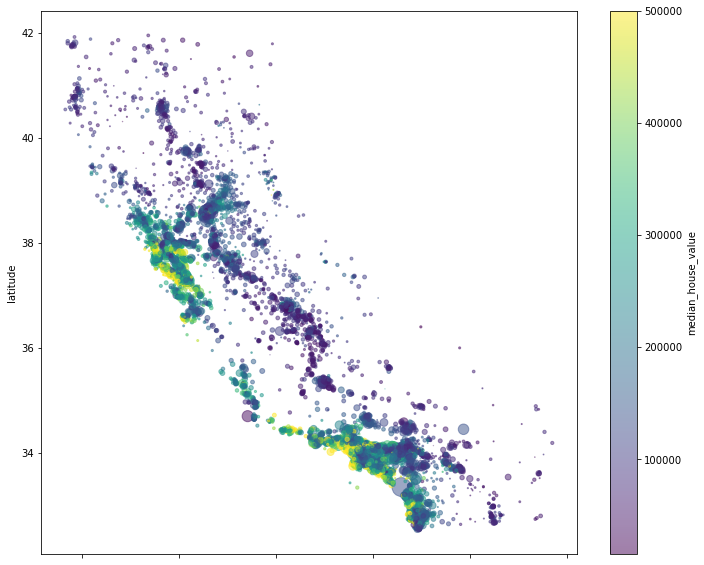

In [47]:
cp_train = strat_train.copy()
cp_train.plot(kind="scatter",
              x="longitude",y="latitude",
              alpha=0.5,s=cp_train["population"]/100,
              figsize=(12,10),c="median_house_value",
             )

In [54]:
cp_train["rooms_per_household"] = cp_train["total_rooms"] / cp_train["households"]
cp_train["bedrooms_per_rooms"] = cp_train["total_bedrooms"] / cp_train["total_rooms"]
cp_train["population_per_household"] = cp_train["population"] / cp_train["households"]
cp_train.corr(numeric_only=True)["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_rooms         -0.259952
Name: median_house_value, dtype: float64

In [24]:
X,y = df.drop(columns=["median_house_value"]),df[["median_house_value"]]
X_train,X_test, y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=42)
# X,y